In [ ]:
import numpy as np

from enhanced_hybrid_hhl import (HHL, 
                                 Lee_preprocessing,  
                                 Yalovetzky_preprocessing,
                                 ideal_preprocessing,
                                 HybridInversion, 
                                 CanonicalInversion,
                                 QuantumLinearSystemProblem, 
                                 QuantumLinearSystemSolver,
                                 EnhancedHybridInversion)

In [396]:
from qiskit_aer import AerSimulator

# define the backend to run the circuits on
simulator = AerSimulator()

In [397]:
# Define quantum linear system problem to be solved with HHL
A_matrix = np.array([[ 0.5 , -0.25],
        [-0.25,  0.5 ]])
b_vector = np.array([[1.], [0.]])
problem = QuantumLinearSystemProblem(A_matrix=A_matrix,
                                     b_vector=b_vector)

# Define Parameters
k = 3 # clock qubits for hhl.
l = k+2 # clock qubits for enhanced preprocessing.
min_prob = 2**-k # hybrid preprocessing relevance threshold.
relevance_threshold = 2**-l # enhanced hybrid preprocessing relevance threshold.
maximum_eigenvalue = 1 # Over estimate of largest eigenvalue in the system.

get_result_type = 'get_swap_test_result'
ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector

In [398]:
# Define a preprocessing function. In this example, we use the standard QPEA used by Lee et al.
enhanced_preprocessing = Lee_preprocessing(num_eval_qubits=l,
                                  max_eigenvalue= maximum_eigenvalue, 
                                  backend=simulator).estimate

enhanced_eigenvalue_inversion = EnhancedHybridInversion

enhanced_hybrid_hhl = HHL(get_result_function= get_result_type,
          preprocessing= enhanced_preprocessing,
          eigenvalue_inversion= enhanced_eigenvalue_inversion,
          backend=simulator,
          statevector=ideal_x_statevector)

enhanced_hybrid_hhl_result = enhanced_hybrid_hhl.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=1)

print(enhanced_hybrid_hhl_result)

{   'circuit_results': {'0 0': 565, '0 1': 442, '1 1': 17},
    'control_state_list': None,
    'eigenbasis_projection_list': [0.0425, 0.41075, 0.0475, 0.39825, 0],
    'eigenvalue_list': [0.8, 0.26666666666666666, 0.2, 0.7333333333333333, 1],
    'ideal_x_statevector': None,
    'job_id': 'e9e38b77-07c1-4aed-a918-3d85624542e3',
    'post_processing': None,
    'results_processed': np.float64(0.9622504486493763),
    'rotation_angle_list': None,
    'shots': None}


In [519]:

def hermitianize_matrix(A, b):
    """
    Convert a general matrix A and vector b to a Hermitian system.
    For a system Ax = b, convert to:
    [[0, A], [A†, 0]] @ [y, x] = [b, 0]
    where A† is the conjugate transpose of A.
    
    Returns the Hermitian matrix and modified b vector.
    """
    A = np.array(A, dtype=complex)
    b = np.array(b).flatten()
    
    n = A.shape[0]
    
    # Create the Hermitian matrix [[0, A], [A†, 0]]
    hermitian_A = np.zeros((2*n, 2*n), dtype=complex)
    hermitian_A[:n, n:] = A
    hermitian_A[n:, :n] = A.conj().T
    
    # Create the modified b vector [b, 0]
    hermitian_b = np.zeros(2*n, dtype=complex)
    hermitian_b[:n] = b
    
    return hermitian_A.real, hermitian_b.real.reshape(-1, 1)

# Create a wrapper for CanonicalInversion to match the HHL interface
def CanonicalInversionWrapper(eigenvalue_list, eigenbasis_projection_list, num_clock_qubits, **kwargs):
    """
    Wrapper for CanonicalInversion to make it compatible with HHL interface.
    
    The CanonicalInversion function only needs num_clock_qubits, but HHL expects
    all inversion functions to take eigenvalue_list, eigenbasis_projection_list, 
    and num_clock_qubits as parameters.
    """
    # Ignore the eigenvalue_list and eigenbasis_projection_list, 
    # just pass num_clock_qubits to CanonicalInversion
    return CanonicalInversion(num_clock_qubits)

In [ ]:
class FixedYalovetzkyPreprocessing(Yalovetzky_preprocessing):
    """
    Fixed version of Yalovetzky_preprocessing that corrects the bug where
    get_result() is called with a parameter when using backend mode.
    """
    
    def estimate(self, problem):
        """
        Fixed estimate method that calls get_result() without parameters
        when using backend mode.
        """
        self.problem = problem

        # If the state_preparation is not specified in the problem, use the standard StatePreparation
        if getattr(problem, 'state_preparation', None) is None:
            from qiskit.circuit.library import StatePreparation
            from qiskit.quantum_info import Statevector
            self.state_preparation = StatePreparation(Statevector(problem.b_vector))
        else:
            self.state_preparation = problem.state_preparation
        
        # If the hamiltonian simulation is not specified in the problem, use the standard HamiltonianGate
        if getattr(problem, 'hamiltonian_simulation', None) is None:
            from qiskit.circuit.library import HamiltonianGate
            import numpy as np
            
            if self.max_eigenvalue == None:
                self.scale = self.find_scale(self.alpha)
            else:
                self.scale = abs((0.5-2**-self.clock)/self.max_eigenvalue)
                self.hamiltonian_simulation = HamiltonianGate(problem.A_matrix, -2*np.pi*self.scale)
        else:
            self.hamiltonian_simulation = problem.hamiltonian_simulation

        if hasattr(self, "max_clock"):
            self.adjust_clock()
            self.scale = abs((0.5-2**-self.clock)/self.max_eigen)
            
        if not hasattr(self, "result"):
            # FIX: Call get_result() without parameters for backend mode
            self.result = self.get_result()
  
        eigenvalue_list = [eig/(self.scale*2**(self.clock)) for eig in self.result.keys() if self.result[eig] > self.min_prob]
        eigenbasis_projection_list = [self.result[eig] for eig in self.result.keys() if self.result[eig] > self.min_prob]
        return eigenvalue_list, eigenbasis_projection_list

Condition Number: 3.5353221654543923
[6.23606798 1.76393202 2.         2.        ]
Probability amplitude |0⟩: 0.344774
Probability P(|0⟩): 0.118869
Probability amplitude |1⟩: 0.610385
Probability P(|1⟩): 0.372570
Probability amplitude |2⟩: 0.610385
Probability P(|2⟩): 0.372570
Probability amplitude |3⟩: 0.368770
Probability P(|3⟩): 0.135991
Classical Solution: [0.27272727 0.5        0.5        0.36363636]
IDEAL HHL STATEVECTOR:  Statevector([0.32444284+0.j, 0.59481188+0.j, 0.59481188+0.j,
             0.43259046+0.j],
            dims=(2, 2))

Normalized classical solution: [0.32444284 0.59481188 0.59481188 0.43259046]
Normalized HHL solution: [0.34477426 0.6103849  0.6103849  0.36876991]
Fidelity between solutions: 0.995031
Cosine similarity: 0.997512
Circuit Depth 353


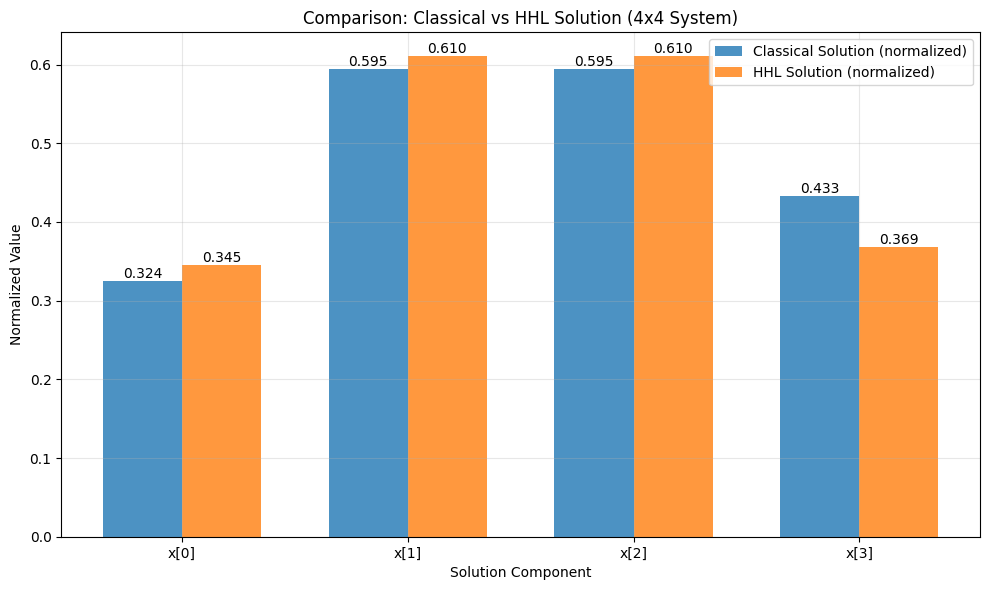

Classical solution (raw): [0.27272727 0.5        0.5        0.36363636]
Classical solution (normalized): [0.32444284 0.59481188 0.59481188 0.43259046]
HHL amplitudes: [0.34477426 0.6103849  0.6103849  0.36876991]
HHL solution (normalized): [0.34477426 0.6103849  0.6103849  0.36876991]
L2 error between normalized solutions: 0.070509


In [ ]:
A_matrix = np.array([[ 6, 0 , 0 , 1],
        [0, 2, 0,0  ],
        [ 0, 0,2,0],
        [1, 0, 0,2  ]])
b_vector = np.array([[2.], [1.], [1.],[1.]])


W_portfolio_6x6 = np.array([
    [0.         , 0.         , 0.30021458, 0.41119151, 0.43015563, 0.46456748],
    [0.         , 0.         , 1.         , 1.         , 1.         , 1.        ],
    [0.30021458 , 1.         , 0.02369003, 0.01330333, 0.01838175, 0.0216144 ],
    [0.41119151 , 1.         , 0.01330333, 0.03111917, 0.01629131, 0.01887668],
    [0.43015563 , 1.         , 0.01838175, 0.01629131, 0.02885482, 0.02333747],
    [0.46456748 , 1.         , 0.0216144 , 0.01887668, 0.02333747, 0.04412049]
])

# Extend to 8x8 matrix for quantum computation
regularization = 1e-8
A_portfolio = np.zeros((8, 8))
A_portfolio[:6, :6] = W_portfolio_6x6
# Add small values to diagonal of padded rows/columns
A_portfolio[6, 6] = regularization
A_portfolio[7, 7] = regularization


# Portfolio optimization right-hand side vector
mu = 0.1  # 10% expected return
xi = 1.0  
b_portfolio_6 = np.array([mu, xi, 0.0, 0.0, 0.0, 0.0])
b_portfolio = np.zeros(8)
b_portfolio[:6] = b_portfolio_6
# A_matrix = A_portfolio
# b_vector = b_portfolio.reshape(-1, 1)

print("Condition Number:", np.linalg.cond(A_matrix))
eigenvals, eigenvector = np.linalg.eig(A_matrix)
print(eigenvals)

# A_h, b_h = hermitianize_matrix(A_matrix,b_vector)
# hermitianize_matrix(A_matrix,b_vector)
A_h , b_h = A_matrix, b_vector

problem = QuantumLinearSystemProblem(A_matrix=A_h,
                                     b_vector=b_h)

# Define Parameters
k = 5 # clock qubits for hhl.
l = k+2 # clock qubits for enhanced preprocessing.
min_prob = 2**-k # hybrid preprocessing relevance threshold.
relevance_threshold = 2**-l # enhanced hybrid preprocessing relevance threshold.
maximum_eigenvalue = 10 # Over estimate of largest eigenvalue in the system.

get_result_type = 'get_simulator_results'
ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector


enhanced_preprocessing = Lee_preprocessing(num_eval_qubits=l,
                                  max_eigenvalue= maximum_eigenvalue, 
                                  backend=simulator).estimate

# Use the fixed Yalovetzky preprocessing (defined in the last cell)
# This fixes the bug where get_result() was called with incorrect parameters
enhanced_preprocessing_2 = FixedYalovetzkyPreprocessing(
    clock=k, 
    max_eigenvalue=maximum_eigenvalue,
    backend=simulator
).estimate

enhanced_eigenvalue_inversion = EnhancedHybridInversion

proj_0_4x4 = Operator([[1, 0,0,0], [0, 0,0,0],[0, 0,0,0],[0, 0,0,0]])

proj_1_4x4 = Operator([[0, 0,0,0], [0, 1,0,0],[0, 0,0,0],[0, 0,0,0]])

proj_2_4x4 = Operator([[0, 0,0,0], [0, 0,0,0],[0, 0,1,0],[0, 0,0,0]])

proj_3_4x4 = Operator([[0, 0,0,0], [0, 0,0,0],[0, 0,0,0],[0, 0,0,1]])

proj_0 = Operator([[1, 0], [0, 0]])

proj_1 = Operator([[0, 0], [0, 1]])

enhanced_hybrid_hhl_0 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_0_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_0 = enhanced_hybrid_hhl_0.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)



current_prob_0 = enhanced_hybrid_hhl_result_0.results_processed.real
print(f"Probability amplitude |0⟩: {current_prob_0:.6f}")
print(f"Probability P(|0⟩): {(current_prob_0**2):.6f}")

enhanced_hybrid_hhl_1 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_1_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_1 = enhanced_hybrid_hhl_1.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)
current_prob_1 = enhanced_hybrid_hhl_result_1.results_processed.real
print(f"Probability amplitude |1⟩: {current_prob_1:.6f}")
print(f"Probability P(|1⟩): {(current_prob_1**2):.6f}")

enhanced_hybrid_hhl_2 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_2_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_2 = enhanced_hybrid_hhl_2.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)



current_prob_2 = enhanced_hybrid_hhl_result_2.results_processed.real
print(f"Probability amplitude |2⟩: {current_prob_2:.6f}")
print(f"Probability P(|2⟩): {(current_prob_2**2):.6f}")

enhanced_hybrid_hhl_3 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing_2,
          operator=proj_3_4x4,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_3 = enhanced_hybrid_hhl_3.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)
current_prob_3 = enhanced_hybrid_hhl_result_3.results_processed.real
print(f"Probability amplitude |3⟩: {current_prob_3:.6f}")
print(f"Probability P(|3⟩): {(current_prob_3**2):.6f}")

classical_solution = np.linalg.solve(A_h, b_h).flatten()  # Flatten for consistency

print("Classical Solution:", classical_solution)
print("IDEAL HHL STATEVECTOR: ", ideal_x_statevector)

# Normalize solutions and calculate fidelity
normalized_classical = classical_solution / np.linalg.norm(classical_solution)
# FIXED: Include ALL 4 measured amplitudes for 4x4 system
hhl_amplitudes = np.array([current_prob_0, current_prob_1, current_prob_2, current_prob_3])
normalized_hhl = hhl_amplitudes / np.linalg.norm(hhl_amplitudes)

print(f"\nNormalized classical solution: {normalized_classical}")
print(f"Normalized HHL solution: {normalized_hhl}")

# Calculate fidelity between normalized solutions
# fidelity = np.abs(np.dot(normalized_classical, normalized_hhl))**2
print(f"Fidelity between solutions: {fidelity:.6f}")

# Also calculate overlap/cosine similarity
# cosine_similarity = np.dot(normalized_classical, normalized_hhl) / (np.linalg.norm(normalized_classical) * np.linalg.norm(normalized_hhl))
print(f"Cosine similarity: {cosine_similarity:.6f}")


enhanced_hybrid_hhl_circuit_depth = HHL(get_result_function='get_fidelity_result',
          preprocessing=enhanced_preprocessing_2,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

# Get the circuit depth by running the algorithm and accessing the circuit
circuit_depth_result = enhanced_hybrid_hhl_circuit_depth.estimate(problem=problem,
                                                                  num_clock_qubits=k,
                                                                  max_eigenvalue=maximum_eigenvalue)
print("Circuit Depth:", circuit_depth_result.circuit_depth)



import matplotlib.pyplot as plt

# Extract the classical solution for the current system
classical_sol = np.linalg.solve(A_matrix, b_vector.flatten())

# Get HHL probabilities - FIXED: All 4 components for 4x4 system
hhl_probs = np.array([current_prob_0, current_prob_1, current_prob_2, current_prob_3])

# Normalize both solutions for comparison
classical_normalized = classical_sol / np.linalg.norm(classical_sol)
hhl_normalized = hhl_probs / np.linalg.norm(hhl_probs)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classical_normalized))
width = 0.35

bars1 = ax.bar(x - width/2, classical_normalized, width, label='Classical Solution (normalized)', alpha=0.8)
bars2 = ax.bar(x + width/2, hhl_normalized, width, label='HHL Solution (normalized)', alpha=0.8)

ax.set_xlabel('Solution Component')
ax.set_ylabel('Normalized Value')
ax.set_title('Comparison: Classical vs HHL Solution (4x4 System)')
ax.set_xticks(x)
ax.set_xticklabels([f'x[{i}]' for i in range(len(classical_normalized))])
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')
                        
for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Classical solution (raw): {classical_sol}")
print(f"Classical solution (normalized): {classical_normalized}")
print(f"HHL amplitudes: {hhl_probs}")
print(f"HHL solution (normalized): {hhl_normalized}")

# Calculate error metrics
amplitude_error = np.linalg.norm(hhl_normalized - classical_normalized)
print(f"L2 error between normalized solutions: {amplitude_error:.6f}")

In [400]:
## CORRECT USAGE OF YALOVETZKY_PREPROCESSING

# The Yalovetzky_preprocessing class requires a 'backend' parameter for proper initialization.
# Here are the correct usage patterns:

# 1. With backend parameter (REQUIRED):
yalovetzky_correct = Yalovetzky_preprocessing(
    clock=k,                           # Number of clock qubits
    max_eigenvalue=maximum_eigenvalue, # Optional: max eigenvalue estimate
    backend=simulator                  # REQUIRED: Backend for quantum execution
)

# 2. Alternative parameters you can use:
yalovetzky_advanced = Yalovetzky_preprocessing(
    clock=3,
    alpha=50,                         # Initial overestimate (used if max_eigenvalue not set)
    max_eigenvalue=2,                 # Max eigenvalue bound
    min_prob=2**-3,                   # Minimum probability threshold
    backend=simulator                 # Always required
)

# 3. To use it as a preprocessing function for HHL:
yalovetzky_preprocessing_function = yalovetzky_correct.estimate

print("✓ Yalovetzky_preprocessing correctly initialized with backend!")
print(f"Clock qubits: {yalovetzky_correct.clock}")
print(f"Max eigenvalue: {yalovetzky_correct.max_eigenvalue}")
print(f"Min probability: {yalovetzky_correct.min_prob}")

# The key difference from your original code:
# WRONG: Yalovetzky_preprocessing(clock=k, max_eigenvalue=maximum_eigenvalue)
# RIGHT: Yalovetzky_preprocessing(clock=k, max_eigenvalue=maximum_eigenvalue, backend=simulator)

✓ Yalovetzky_preprocessing correctly initialized with backend!
Clock qubits: 2
Max eigenvalue: 2
Min probability: 0.25


In [401]:

# enhanced_hybrid_hhl = HHL(get_result_function= get_result_type,
#           preprocessing= enhanced_preprocessing,
#           operator = 
#           eigenvalue_inversion= enhanced_eigenvalue_inversion,
#           backend=simulator,
#           statevector=ideal_x_statevector)

# enhanced_hybrid_hhl_result = enhanced_hybrid_hhl.estimate(problem=problem,
#                                                           num_clock_qubits=k,
#                                                           max_eigenvalue=1)



=== SYSTEM DEFINITION ===
A_matrix = 
[[2 6]
 [0 2]]
b_vector = 
[[1.]
 [1.]]
Classical solution = [-1.   0.5]

Hermitianized system shapes: A_h (4, 4), b_h (4, 1)

=== PROJECTION OPERATORS ===
Projection operator |0⟩⟨0|:
Matrix:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Projection operator |1⟩⟨1|:
Matrix:
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

=== RUNNING HHL COMPUTATION ===
Running HHL with |0⟩⟨0| projection...
Probability P(|0⟩): 0.575690
Running HHL with |1⟩⟨1| projection...
Probability P(|1⟩): 0.817497

=== RESULTS SUMMARY ===
Measured probabilities: P(|0⟩) = 0.575690, P(|1⟩) = 0.817497
Sum of probabilities: 1.393188
Expected probabilities (hermitianized): P(|0⟩) = 0.000000, P(|1⟩) = 0.000000, P(|2⟩) = 0.800000, P(|3⟩) = 0.200000
Classical solution (original): [-1.   0.5]
Circuit depths: P(|0⟩) = 49, P(|1⟩) = 49

*** TO UPDATE SYSTEM: Change A_matrix and b_vector above, then re-run this cell ***


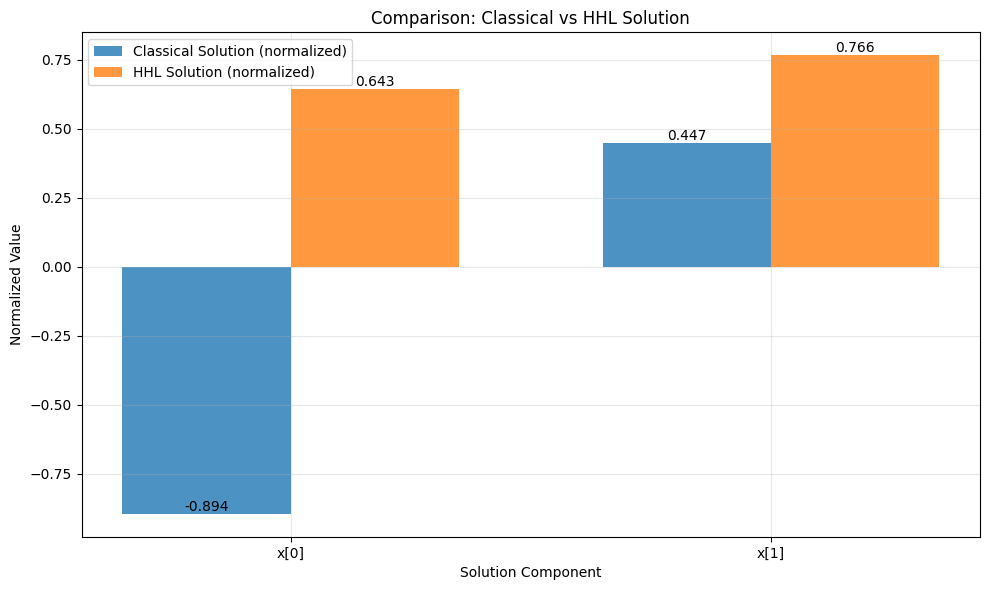

Classical solution (raw): [-1.   0.5]
Classical solution (normalized): [-0.89442719  0.4472136 ]
HHL probabilities: [0.57569049 0.81749742]
HHL solution (normalized): [0.64282044 0.76601689]


In [507]:
# Import Operator for projection measurements
from qiskit.quantum_info import Operator


# === SYSTEM DEFINITION ===
# Change these values to test different systems:
A_matrix = np.array([[ 2, 6],
        [0, 2  ]])
b_vector = np.array([[1.], [1.]])

print("=== SYSTEM DEFINITION ===")
print(f"A_matrix = \n{A_matrix}")
print(f"b_vector = \n{b_vector}")
print(f"Classical solution = {np.linalg.solve(A_matrix, b_vector.flatten())}")

# Create hermitianized system using the function from cell 5
A_h, b_h = hermitianize_matrix(A_matrix, b_vector)

print(f"\nHermitianized system shapes: A_h {A_h.shape}, b_h {b_h.shape}")

problem = QuantumLinearSystemProblem(A_matrix=A_h,
                                     b_vector=b_h)

# Define Parameters
k = 2 # clock qubits for hhl.
l = k+2 # clock qubits for enhanced preprocessing.
min_prob = 2**-k # hybrid preprocessing relevance threshold.
relevance_threshold = 2**-l # enhanced hybrid preprocessing relevance threshold.
maximum_eigenvalue = 2 # Over estimate of largest eigenvalue in the system.

get_result_type = 'get_simulator_results'
ideal_x_statevector = QuantumLinearSystemSolver(problem=problem).ideal_x_statevector


enhanced_preprocessing = Lee_preprocessing(num_eval_qubits=l,
                                  max_eigenvalue= maximum_eigenvalue, 
                                  backend=simulator).estimate

enhanced_eigenvalue_inversion = EnhancedHybridInversion



# Create projection operators for qubits 0 and 1
# Projection operator |0⟩⟨0| - measures probability of qubit 0
proj_0 = Operator([[1, 0], [0, 0]])
print(f"\n=== PROJECTION OPERATORS ===")
print(f"Projection operator |0⟩⟨0|:")
print(f"Matrix:\n{proj_0.data}")

# Projection operator |1⟩⟨1| - measures probability of qubit 1  
proj_1 = Operator([[0, 0], [0, 1]])
print(f"\nProjection operator |1⟩⟨1|:")
print(f"Matrix:\n{proj_1.data}")

# === HHL COMPUTATION ===
print(f"\n=== RUNNING HHL COMPUTATION ===")

# Run HHL with projection operator for qubit 0
print(f"Running HHL with |0⟩⟨0| projection...")
enhanced_hybrid_hhl_0 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing,
          operator=proj_0,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_0 = enhanced_hybrid_hhl_0.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)

current_prob_0 = enhanced_hybrid_hhl_result_0.results_processed.real
print(f"Probability P(|0⟩): {current_prob_0:.6f}")

# Run HHL with projection operator for qubit 1
print(f"Running HHL with |1⟩⟨1| projection...")
enhanced_hybrid_hhl_1 = HHL(get_result_function='get_simulator_result',
          preprocessing=enhanced_preprocessing,
          operator=proj_1,
          eigenvalue_inversion=EnhancedHybridInversion,
          backend=simulator)

enhanced_hybrid_hhl_result_1 = enhanced_hybrid_hhl_1.estimate(problem=problem,
                                                          num_clock_qubits=k,
                                                          max_eigenvalue=maximum_eigenvalue)

current_prob_1 = enhanced_hybrid_hhl_result_1.results_processed.real
print(f"Probability P(|1⟩): {current_prob_1:.6f}")

# === RESULTS SUMMARY ===
print(f"\n=== RESULTS SUMMARY ===")
print(f"Measured probabilities: P(|0⟩) = {current_prob_0:.6f}, P(|1⟩) = {current_prob_1:.6f}")
print(f"Sum of probabilities: {current_prob_0 + current_prob_1:.6f}")

# Compare with ideal solution
ideal_probs = np.abs(ideal_x_statevector.data)**2
print(f"Expected probabilities (hermitianized): P(|0⟩) = {ideal_probs[0]:.6f}, P(|1⟩) = {ideal_probs[1]:.6f}, P(|2⟩) = {ideal_probs[2]:.6f}, P(|3⟩) = {ideal_probs[3]:.6f}")
print(f"Classical solution (original): {np.linalg.solve(A_matrix, b_vector.flatten())}")

# Show circuit depths
print(f"Circuit depths: P(|0⟩) = {enhanced_hybrid_hhl_result_0.circuit_depth}, P(|1⟩) = {enhanced_hybrid_hhl_result_1.circuit_depth}")

print(f"\n*** TO UPDATE SYSTEM: Change A_matrix and b_vector above, then re-run this cell ***")


import matplotlib.pyplot as plt

# Extract the classical solution for the current system
classical_sol = np.linalg.solve(A_matrix, b_vector.flatten())

# Get HHL probabilities (only for measured qubits)
hhl_probs = np.array([current_prob_0, current_prob_1])

# Normalize both solutions for comparison
classical_normalized = classical_sol / np.linalg.norm(classical_sol)
hhl_normalized = np.sqrt(hhl_probs) / np.linalg.norm(np.sqrt(hhl_probs))

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classical_normalized))
width = 0.35

bars1 = ax.bar(x - width/2, classical_normalized, width, label='Classical Solution (normalized)', alpha=0.8)
bars2 = ax.bar(x + width/2, hhl_normalized, width, label='HHL Solution (normalized)', alpha=0.8)

ax.set_xlabel('Solution Component')
ax.set_ylabel('Normalized Value')
ax.set_title('Comparison: Classical vs HHL Solution')
ax.set_xticks(x)
ax.set_xticklabels([f'x[{i}]' for i in range(len(classical_normalized))])
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')
                        
for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Classical solution (raw): {classical_sol}")
print(f"Classical solution (normalized): {classical_normalized}")
print(f"HHL probabilities: {hhl_probs}")
print(f"HHL solution (normalized): {hhl_normalized}")

In [403]:
def analyze_hhl_solution_accuracy(A_matrix, b_vector, prob_0, prob_1, A_hermitianized=None, b_hermitianized=None):
    """
    Comprehensive analysis comparing HHL results to classical solution.
    
    Parameters:
    - A_matrix, b_vector: Original system to solve
    - prob_0, prob_1: Measured probabilities from HHL
    - A_hermitianized, b_hermitianized: Hermitianized system used for HHL (optional)
    """
    print("="*70)
    print("HHL SOLUTION ACCURACY ANALYSIS")
    print("="*70)
    
    # 1. Classical Solution (Ground Truth)
    print("1. CLASSICAL SOLUTION (Ground Truth):")
    classical_solution = np.linalg.solve(A_matrix, b_vector).flatten()  # Flatten for consistency
    print(f"   x_classical = {classical_solution}")
    print(f"   ||x_classical|| = {np.linalg.norm(classical_solution):.6f}")
    
    # 2. Ideal Quantum Solution (if A is Hermitian)
    print("\n2. IDEAL QUANTUM SOLUTION:")
    try:
        # Check if original A is Hermitian
        if np.allclose(A_matrix, np.conj(A_matrix).T):
            problem = QuantumLinearSystemProblem(A_matrix=A_matrix, b_vector=b_vector.flatten())
            ideal_statevector = QuantumLinearSystemSolver(problem).ideal_x_statevector
            ideal_probabilities = np.abs(ideal_statevector.data)**2
            ideal_norm_squared = np.sum(ideal_probabilities)
            normalized_ideal_probs = ideal_probabilities / ideal_norm_squared
            print(f"   Ideal probabilities: {normalized_ideal_probs}")
            print(f"   Ideal norm squared: {ideal_norm_squared:.6f}")
        else:
            print("   Original matrix is not Hermitian - using hermitianized system for ideal solution")
            if A_hermitianized is not None and b_hermitianized is not None:
                problem = QuantumLinearSystemProblem(A_matrix=A_hermitianized, b_vector=b_hermitianized)
                ideal_statevector = QuantumLinearSystemSolver(problem).ideal_x_statevector
                ideal_probabilities = np.abs(ideal_statevector.data)**2
                ideal_norm_squared = np.sum(ideal_probabilities)
                normalized_ideal_probs = ideal_probabilities / ideal_norm_squared
                print(f"   Ideal probabilities (hermitianized): {normalized_ideal_probs}")
                print(f"   Ideal norm squared: {ideal_norm_squared:.6f}")
                # Extract relevant components (first 2 for original system)
                n_orig = len(classical_solution)
                ideal_solution = normalized_ideal_probs[:n_orig]
                print(f"   Ideal solution (extracted): {ideal_solution}")
            else:
                print("   Cannot compute ideal solution - hermitianized system not provided")
                ideal_solution = None
                normalized_ideal_probs = None
    except Exception as e:
        print(f"   Error computing ideal solution: {e}")
        ideal_solution = None
        normalized_ideal_probs = None
    
    # 3. HHL Measured Results
    print("\n3. HHL MEASURED RESULTS:")
    hhl_probabilities = np.array([prob_0, prob_1])
    hhl_norm_squared = np.sum(hhl_probabilities)
    normalized_hhl_probs = hhl_probabilities / hhl_norm_squared
    print(f"   Raw probabilities: {hhl_probabilities}")
    print(f"   Normalized probabilities: {normalized_hhl_probs}")
    print(f"   Norm squared: {hhl_norm_squared:.6f}")
    
    # 4. Error Analysis
    print("\n4. ERROR ANALYSIS:")
    
    # Classical vs HHL comparison (using squared amplitudes)
    if len(normalized_hhl_probs) == len(classical_solution):
        # Normalize classical solution and take probabilities (squared amplitudes)
        normalized_classical = classical_solution / np.linalg.norm(classical_solution)
        classical_probabilities = np.abs(normalized_classical)**2  # Take absolute value for complex cases
        
        prob_error = np.linalg.norm(normalized_hhl_probs - classical_probabilities)
        print(f"   Classical probabilities (|x_norm|²): {classical_probabilities}")
        print(f"   HHL vs Classical probability error: {prob_error:.6f}")
        
        # Also compare amplitudes
        hhl_amplitudes = np.sqrt(normalized_hhl_probs) * np.sign(normalized_classical)
        amplitude_error = np.linalg.norm(hhl_amplitudes - normalized_classical)
        print(f"   Reconstructed amplitudes: {hhl_amplitudes}")
        print(f"   HHL vs Classical amplitude error: {amplitude_error:.6f}")
    else:
        print("   Dimension mismatch - cannot directly compare probabilities")
    
    # Ideal vs HHL comparison
    if normalized_ideal_probs is not None:
        if len(normalized_hhl_probs) == len(normalized_ideal_probs):
            ideal_error = np.linalg.norm(normalized_hhl_probs - normalized_ideal_probs)
            print(f"   HHL vs Ideal error: {ideal_error:.6f}")
        else:
            # Extract relevant components if dimensions don't match
            n_hhl = len(normalized_hhl_probs)
            if len(normalized_ideal_probs) > n_hhl:
                ideal_extracted = normalized_ideal_probs[:n_hhl]
                ideal_error = np.linalg.norm(normalized_hhl_probs - ideal_extracted)
                print(f"   HHL vs Ideal error (extracted): {ideal_error:.6f}")
    
    # 5. Solution Reconstruction
    print("\n5. SOLUTION RECONSTRUCTION:")
    # Try to reconstruct solution from probabilities with correct signs
    if len(normalized_hhl_probs) == len(classical_solution):
        normalized_classical = classical_solution / np.linalg.norm(classical_solution)
        reconstructed_solution = np.sqrt(normalized_hhl_probs) * np.sign(normalized_classical)
        
        # Scale back to original magnitude (approximately)
        scale_factor = np.linalg.norm(classical_solution)
        reconstructed_solution_scaled = reconstructed_solution * scale_factor
        
        print(f"   Reconstructed (normalized): {reconstructed_solution}")
        print(f"   Reconstructed (scaled): {reconstructed_solution_scaled}")
        
        reconstruction_error = np.linalg.norm(reconstructed_solution - normalized_classical)
        scaled_reconstruction_error = np.linalg.norm(reconstructed_solution_scaled - classical_solution)
        print(f"   Reconstruction error (normalized): {reconstruction_error:.6f}")
        print(f"   Reconstruction error (scaled): {scaled_reconstruction_error:.6f}")
    else:
        reconstructed_solution = np.sqrt(normalized_hhl_probs)
        print(f"   Basic reconstruction: {reconstructed_solution}")
    
    print("="*70)
    
    return {
        'classical_solution': classical_solution,
        'hhl_probabilities': normalized_hhl_probs,
        'ideal_probabilities': normalized_ideal_probs,
        'reconstructed_solution': reconstructed_solution if 'reconstructed_solution' in locals() else None
    }


def hermitianize_matrix(A):
    """
    Hermitianize a matrix using the block structure:
    [[0, A], [A†, 0]]
    """
    A_dag = np.conj(A).T
    n = A.shape[0]
    A_h = np.zeros((2*n, 2*n), dtype=complex)
    A_h[:n, n:] = A
    A_h[n:, :n] = A_dag
    return A_h


def create_hermitianized_system(A, b):
    """
    Create a hermitianized system for non-Hermitian matrices.
    Returns (A_h, b_h) where A_h is Hermitian and the solution
    contains the original solution in its first components.
    """
    A_h = hermitianize_matrix(A)
    
    # Create hermitianized b vector [b, 0]
    n = len(b)
    b_h = np.zeros(2*n, dtype=complex)
    b_h[:n] = b
    
    return A_h, b_h


# Create projection operators for measuring the first 2 qubits
# (since we want to extract the solution to the original 2x2 system)

# |0⟩⟨0| ⊗ |0⟩⟨0| - projects onto |00⟩
proj_0_single = np.array([[1, 0], [0, 0]])
proj_0 = Operator(np.kron(proj_0_single, proj_0_single))

# |0⟩⟨0| ⊗ |1⟩⟨1| - projects onto |01⟩  
proj_1_single = np.array([[0, 0], [0, 1]])
proj_1 = Operator(np.kron(proj_0_single, proj_1_single))

print("Projection operators created:")
print(f"proj_0 shape: {proj_0.dim}")
print(f"proj_1 shape: {proj_1.dim}")
print("These project onto |00⟩ and |01⟩ states respectively")

Projection operators created:
proj_0 shape: (4, 4)
proj_1 shape: (4, 4)
These project onto |00⟩ and |01⟩ states respectively


In [404]:
# Use existing measurement results
print("Using existing HHL measurement results:")
print(f"P(|0⟩) = {current_prob_0:.6f}")
print(f"P(|1⟩) = {current_prob_1:.6f}")

print(f"\nOriginal system:")
print(f"A_matrix = \n{A_matrix}")
print(f"b_vector = {b_vector}")
classical_solution = np.linalg.solve(A_matrix, b_vector)
print(f"Classical solution = {classical_solution}")

# Run analysis on the ORIGINAL system for meaningful comparison
print("Running analysis on ORIGINAL system for meaningful comparison...")
analysis_results = analyze_hhl_solution_accuracy(
    A_matrix, b_vector, current_prob_0, current_prob_1, 
    A_hermitianized=A_h, b_hermitianized=b_h
)

print("\n" + "="*70)
print("NOTE: The HHL was run on hermitianized system, but analysis compares to original")
print("system for meaningful interpretation of the quantum solution.")
print("="*70)

Using existing HHL measurement results:
P(|0⟩) = 0.579657
P(|1⟩) = 0.814861

Original system:
A_matrix = 
[[2 6]
 [0 2]]
b_vector = [[1.]
 [1.]]
Classical solution = [[-1. ]
 [ 0.5]]
Running analysis on ORIGINAL system for meaningful comparison...
HHL SOLUTION ACCURACY ANALYSIS
1. CLASSICAL SOLUTION (Ground Truth):
   x_classical = [-1.   0.5]
   ||x_classical|| = 1.118034

2. IDEAL QUANTUM SOLUTION:
   Original matrix is not Hermitian - using hermitianized system for ideal solution
   Ideal probabilities (hermitianized): [0.  0.  0.8 0.2]
   Ideal norm squared: 1.000000
   Ideal solution (extracted): [0. 0.]

3. HHL MEASURED RESULTS:
   Raw probabilities: [0.57965679 0.81486073]
   Normalized probabilities: [0.41566835 0.58433165]
   Norm squared: 1.394518

4. ERROR ANALYSIS:
   Classical probabilities (|x_norm|²): [0.8 0.2]
   HHL vs Classical probability error: 0.543527
   Reconstructed amplitudes: [-0.64472347  0.76441589]
   HHL vs Classical amplitude error: 0.403694
   HHL vs Ide

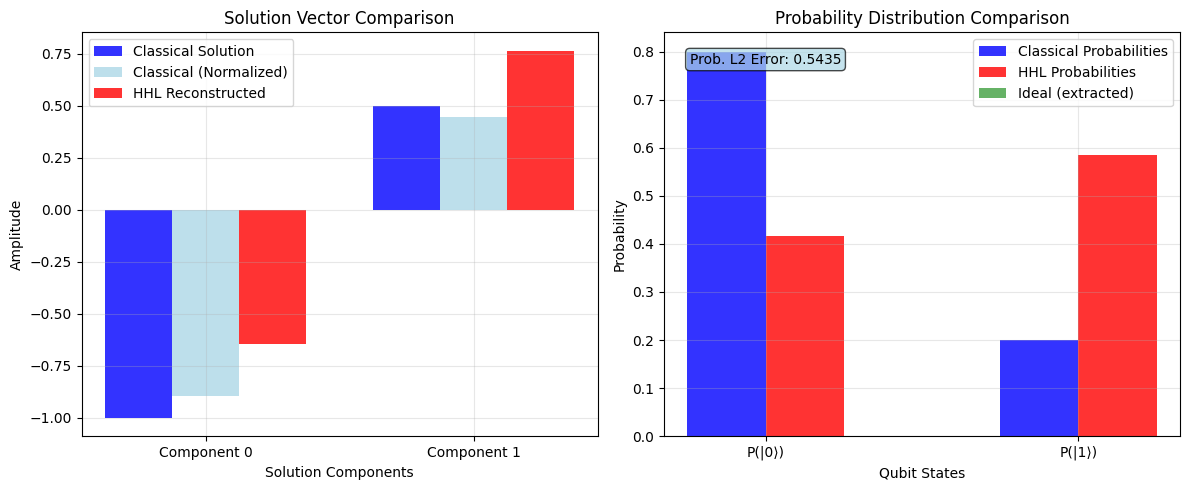


SOLUTION COMPARISON SUMMARY
Classical solution: [-1.   0.5]
Classical norm: 1.118034
HHL probabilities: [0.41566835 0.58433165]
Reconstructed solution: [-0.64472347  0.76441589]
Reconstruction error: 0.403694
Cosine similarity: 0.918515


In [405]:
import matplotlib.pyplot as plt

def visualize_solution_comparison(analysis_results):
    """Create visual comparison of classical vs HHL solutions"""
    
    classical = analysis_results['classical_solution']
    hhl_probs = analysis_results['hhl_probabilities'] 
    ideal_probs = analysis_results['ideal_probabilities']
    reconstructed = analysis_results['reconstructed_solution']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Solution vectors comparison
    x_labels = ['Component 0', 'Component 1']
    x_pos = np.arange(len(x_labels))
    
    width = 0.25
    
    # Normalize classical for comparison
    classical_norm = classical / np.linalg.norm(classical)
    
    ax1.bar(x_pos - width, classical, width, label='Classical Solution', alpha=0.8, color='blue')
    ax1.bar(x_pos, classical_norm, width, label='Classical (Normalized)', alpha=0.8, color='lightblue')
    if reconstructed is not None:
        ax1.bar(x_pos + width, reconstructed, width, label='HHL Reconstructed', alpha=0.8, color='red')
    
    ax1.set_xlabel('Solution Components')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Solution Vector Comparison')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Probability comparison
    classical_probs = np.abs(classical_norm)**2
    
    ax2.bar(x_pos - width/2, classical_probs, width, label='Classical Probabilities', alpha=0.8, color='blue')
    ax2.bar(x_pos + width/2, hhl_probs, width, label='HHL Probabilities', alpha=0.8, color='red')
    
    if ideal_probs is not None and len(ideal_probs) >= 2:
        # Extract first 2 components if available
        ideal_extracted = ideal_probs[:2] if len(ideal_probs) > 2 else ideal_probs
        ax2.bar(x_pos, ideal_extracted, width/2, label='Ideal (extracted)', alpha=0.6, color='green')
    
    ax2.set_xlabel('Qubit States')
    ax2.set_ylabel('Probability')
    ax2.set_title('Probability Distribution Comparison')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(['P(|0⟩)', 'P(|1⟩)'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Calculate and display errors
    prob_error = np.linalg.norm(hhl_probs - classical_probs)
    ax2.text(0.05, 0.95, f'Prob. L2 Error: {prob_error:.4f}', transform=ax2.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("SOLUTION COMPARISON SUMMARY")
    print("="*60)
    print(f"Classical solution: {classical}")
    print(f"Classical norm: {np.linalg.norm(classical):.6f}")
    print(f"HHL probabilities: {hhl_probs}")
    if reconstructed is not None:
        print(f"Reconstructed solution: {reconstructed}")
        reconstruction_error = np.linalg.norm(reconstructed - classical_norm)
        print(f"Reconstruction error: {reconstruction_error:.6f}")
    
    # Calculate cosine similarity if possible
    if reconstructed is not None and len(reconstructed) == len(classical):
        cos_sim = np.dot(reconstructed, classical_norm) / (np.linalg.norm(reconstructed) * np.linalg.norm(classical_norm))
        print(f"Cosine similarity: {cos_sim:.6f}")
    
    print("="*60)

# Run visualization if analysis results are available
if 'analysis_results' in globals():
    visualize_solution_comparison(analysis_results)
else:
    print("Analysis results not found. Run the analysis cell first.")

In [ ]:
# SOLUTION: Fixed Yalovetzky_preprocessing wrapper



# Now use the fixed version
print("Creating fixed Yalovetzky preprocessing...")
fixed_yalovetzky = FixedYalovetzkyPreprocessing(
    clock=k,
    max_eigenvalue=maximum_eigenvalue,
    backend=simulator
)

print("✅ Fixed Yalovetzky preprocessing created successfully!")
print(f"Clock qubits: {fixed_yalovetzky.clock}")
print(f"Max eigenvalue: {fixed_yalovetzky.max_eigenvalue}")
print(f"Backend: {type(fixed_yalovetzky.backend).__name__}")

Creating fixed Yalovetzky preprocessing...
✅ Fixed Yalovetzky preprocessing created successfully!
Clock qubits: 2
Max eigenvalue: 2
Backend: AerSimulator


In [ ]:
# Portfolio Optimization Matrix for HHL (8x8)
import numpy as np
from qiskit.quantum_info import Operator

# Original 6x6 portfolio optimization matrix
W_portfolio_6x6 = np.array([
    [0.         , 0.         , 0.30021458, 0.41119151, 0.43015563, 0.46456748],
    [0.         , 0.         , 1.         , 1.         , 1.         , 1.        ],
    [0.30021458 , 1.         , 0.02369003, 0.01330333, 0.01838175, 0.0216144 ],
    [0.41119151 , 1.         , 0.01330333, 0.03111917, 0.01629131, 0.01887668],
    [0.43015563 , 1.         , 0.01838175, 0.01629131, 0.02885482, 0.02333747],
    [0.46456748 , 1.         , 0.0216144 , 0.01887668, 0.02333747, 0.04412049]
])

# Extend to 8x8 matrix for quantum computation
A_portfolio = np.zeros((8, 8))
A_portfolio[:6, :6] = W_portfolio_6x6

# Portfolio optimization right-hand side vector
mu = 0.1  # 10% expected return
xi = 1.0  
b_portfolio_6 = np.array([mu, xi, 0.0, 0.0, 0.0, 0.0])
b_portfolio = np.zeros(8)
b_portfolio[:6] = b_portfolio_6

print("Portfolio Optimization Matrix (8x8):")
print(A_portfolio)
print(f"\nRHS vector: {b_portfolio}")

# Create quantum problem
problem_portfolio = QuantumLinearSystemProblem(
    A_matrix=A_portfolio,
    b_vector=b_portfolio.reshape(-1, 1)
)

print(f"\n✓ Created 8x8 portfolio problem for HHL")